<a href="https://colab.research.google.com/github/micah-shull/Statistics/blob/main/Statistics_30_hypothesis_testing_cars_acceleration_origin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Question**
Does the average acceleration differ between cars from the USA, Europe, and Japan?

---

### **Hypotheses**:
- **Null Hypothesis (H₀)**:  
  The mean acceleration is the same across all origin groups (USA, Europe, Japan).  
  *In other words, origin has no effect on the average acceleration of cars.*

- **Alternative Hypothesis (H₁)**:  
  At least one origin group has a different mean acceleration.  
  *In other words, the mean acceleration differs between at least two origins.*

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import levene

# Load the dataset
cars = sns.load_dataset('mpg')

# Print the number of unique values for each column
unique_counts = cars.nunique()

# Define a threshold for unique values to classify as categorical
threshold = 10

# Identify columns to convert to categorical
categorical_cols = unique_counts[unique_counts < threshold].index.tolist()

# Convert suitable columns to category
for col in categorical_cols:
    cars[col] = cars[col].astype('category')

# Verify the changes
print(cars.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   mpg           398 non-null    float64 
 1   cylinders     398 non-null    category
 2   displacement  398 non-null    float64 
 3   horsepower    392 non-null    float64 
 4   weight        398 non-null    int64   
 5   acceleration  398 non-null    float64 
 6   model_year    398 non-null    int64   
 7   origin        398 non-null    category
 8   name          398 non-null    object  
dtypes: category(2), float64(4), int64(2), object(1)
memory usage: 23.0+ KB
None


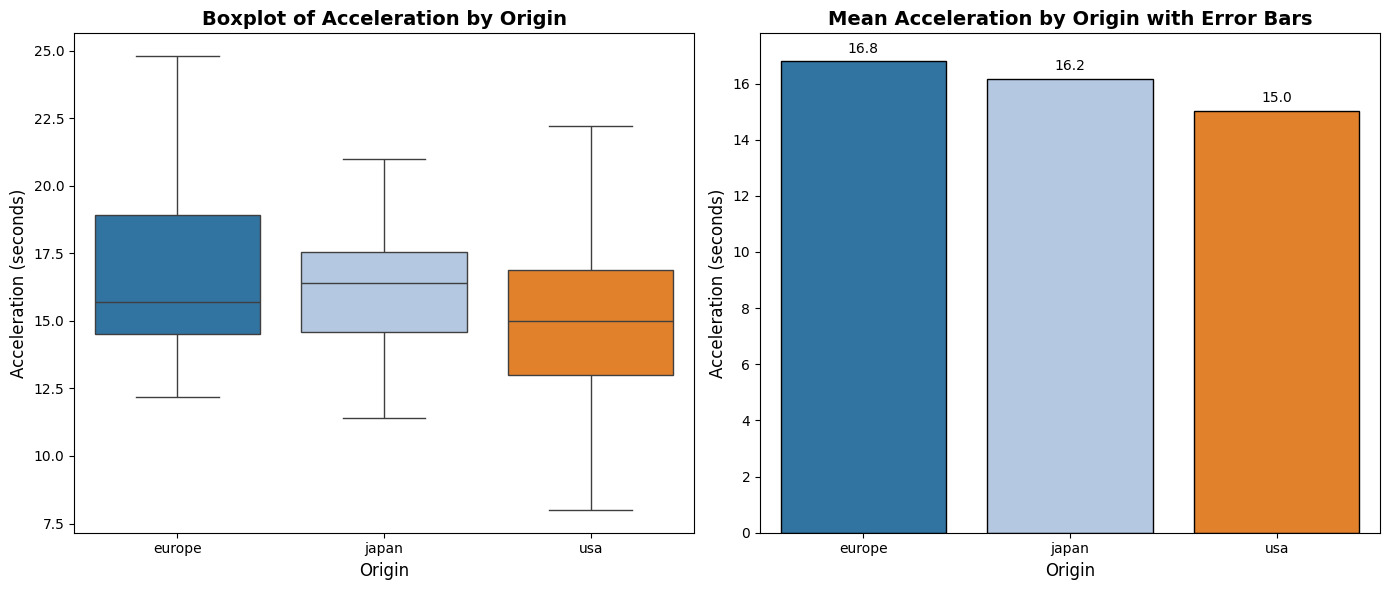

In [2]:
# Calculate the means, standard deviations, and counts for acceleration by origin
group_stats = cars.groupby('origin', observed=True)['acceleration'].agg(['mean', 'std', 'count']).reset_index()
group_stats['error'] = group_stats['std'] / group_stats['count']**0.5  # Standard error of the mean

# Define the color palette
palette = sns.color_palette("tab20", n_colors=3)

# Set up the figure with a 1x2 grid
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Boxplot
sns.boxplot(data=cars, x='origin', y='acceleration', hue='origin', palette=palette, ax=axes[0])
axes[0].set_title('Boxplot of Acceleration by Origin', fontsize=14, weight='bold')
axes[0].set_xlabel('Origin', fontsize=12)
axes[0].set_ylabel('Acceleration (seconds)', fontsize=12)

# Plot 2: Barplot with Error Bars
sns.barplot(data=group_stats, x='origin', y='mean', hue='origin', palette=palette, ax=axes[1], edgecolor='black', errorbar=None)

# # Add error bars to the barplot
# for index, row in group_stats.iterrows():
#     axes[1].errorbar(x=index, y=row['mean'], yerr=row['error'], fmt='none', c='black', capsize=5)

# Add data labels to the barplot
for index, row in group_stats.iterrows():
    axes[1].text(index, row['mean'] + 0.3, f"{row['mean']:.1f}", ha='center', fontsize=10)

axes[1].set_title('Mean Acceleration by Origin with Error Bars', fontsize=14, weight='bold')
axes[1].set_xlabel('Origin', fontsize=12)
axes[1].set_ylabel('Acceleration (seconds)', fontsize=12)
axes[1].set_ylim(0, group_stats['mean'].max() + 1)  # Adjust y-axis for labels

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [5]:
# !pip install pingouin

In [8]:
from scipy.stats import levene
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pingouin as pg

# Group acceleration by origin
usa_accel = cars[cars['origin'] == 'usa']['acceleration']
europe_accel = cars[cars['origin'] == 'europe']['acceleration']
japan_accel = cars[cars['origin'] == 'japan']['acceleration']

# Perform Levene's Test
levene_stat, levene_p = levene(usa_accel, europe_accel, japan_accel)
print(f"Levene's Test Statistic: {levene_stat:.2f}")
print(f"P-Value: {levene_p:.4f}")

# Interpretation
if levene_p < 0.05:
    print("\nReject the Null Hypothesis: Variances in acceleration differ across origin groups.")
else:
    print("\nFail to Reject the Null Hypothesis: Variances in acceleration are similar across origin groups.")

# Perform Welch's ANOVA
welch_anova = pg.welch_anova(data=cars, dv='acceleration', between='origin')
print(welch_anova)

# Interpretation
if welch_anova['p-unc'][0] < 0.05:
    print("\nReject the Null Hypothesis: The mean acceleration differs significantly across origin groups.")
else:
    print("\nFail to Reject the Null Hypothesis: The mean acceleration is the same across origin groups.")
print('\n')

# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=cars['acceleration'], groups=cars['origin'], alpha=0.05)
print(tukey)

Levene's Test Statistic: 4.23
P-Value: 0.0153

Reject the Null Hypothesis: Variances in acceleration differ across origin groups.
   Source  ddof1       ddof2          F     p-unc       np2
0  origin      2  151.437556  13.876385  0.000003  0.067553

Reject the Null Hypothesis: The mean acceleration differs significantly across origin groups.


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
europe  japan   -0.615 0.3401 -1.6459  0.4159  False
europe    usa  -1.7534    0.0 -2.6031 -0.9037   True
 japan    usa  -1.1384  0.003 -1.9494 -0.3274   True
----------------------------------------------------




### **Updated Interpretation of the Results**

#### **1. Levene's Test for Variances**
- **Test Statistic**: 4.23  
- **P-Value**: 0.0153  
  - The p-value is below the significance threshold (\( \alpha = 0.05 \)), so we **reject the null hypothesis**.
  - **Conclusion**: The variances in acceleration differ significantly across the `origin` groups. This result justifies using **Welch's ANOVA**, which is robust to unequal variances.

---

#### **2. Welch’s ANOVA**
- **F-Statistic**: 13.88  
- **P-Value**: \( 0.000003 \)  
  - The p-value is far below \( \alpha = 0.05 \), so we **reject the null hypothesis**.
  - **Conclusion**: The mean acceleration differs significantly across the `origin` groups.

- **Effect Size (\( \eta^2_p \))**: 0.068  
  - Approximately 6.8% of the variability in acceleration is explained by differences between the origin groups.
  - This indicates a **small-to-moderate effect size**.

---

#### **3. Tukey’s HSD Test (Post-Hoc Analysis)**

1. **Europe vs. Japan**:
   - **Mean Difference**: -0.62  
   - \( p = 0.3401 \): Not significant.  
   - **Conclusion**: There is no significant difference in mean acceleration between Europe and Japan.

2. **Europe vs. USA**:
   - **Mean Difference**: -1.75  
   - \( p = 0.0000 \): Highly significant.  
   - **Conclusion**: Cars from the USA have significantly slower acceleration compared to cars from Europe.

3. **Japan vs. USA**:
   - **Mean Difference**: -1.14  
   - \( p = 0.0030 \): Significant.  
   - **Conclusion**: Cars from the USA have significantly slower acceleration compared to cars from Japan.

---

### **Key Insights**
1. **Variances**:
   - Variances in acceleration differ significantly across origin groups. This justifies using Welch's ANOVA instead of standard ANOVA.

2. **Mean Differences**:
   - **USA cars** have the slowest mean acceleration, significantly slower than both Europe and Japan.
   - **Europe and Japan cars** have similar mean acceleration.

3. **Effect Size**:
   - The differences in mean acceleration explain about **6.8%** of the variability, indicating a small-to-moderate relationship.





## **Question**:
Is there a significant relationship between a car's weight and its acceleration?

---

### **Testing Weight and Acceleration**

#### **Hypotheses**:
- **Null Hypothesis (H₀):**  
  There is no relationship between weight and acceleration.  
  *In other words, the correlation between weight and acceleration is zero.*

- **Alternative Hypothesis (H₁):**  
  There is a relationship between weight and acceleration.  
  *In other words, the correlation between weight and acceleration is not zero.*

---

#### **Testing Approach**:
1. **Pearson Correlation**:
   - If the relationship is **linear**, use the Pearson correlation coefficient to test for a significant correlation.
2. **Spearman Correlation**:
   - If the relationship is **non-linear**, use the Spearman rank correlation as a non-parametric alternative.
3. **Visualization**:
   - Use a scatterplot with a regression line to visually explore the relationship.

In [9]:
from scipy.stats import pearsonr, spearmanr

# Drop missing values for weight and acceleration
cars_clean = cars.dropna(subset=['weight', 'acceleration'])

# Calculate Pearson Correlation
pearson_corr, pearson_p = pearsonr(cars_clean['weight'], cars_clean['acceleration'])
print(f"Pearson Correlation Coefficient: {pearson_corr:.2f}")
print(f"Pearson P-Value: {pearson_p:.4f}")

# Calculate Spearman Correlation
spearman_corr, spearman_p = spearmanr(cars_clean['weight'], cars_clean['acceleration'])
print(f"Spearman Correlation Coefficient: {spearman_corr:.2f}")
print(f"Spearman P-Value: {spearman_p:.4f}")

# Interpretation
alpha = 0.05
if pearson_p < alpha:
    print("\nReject the Null Hypothesis: There is a significant linear relationship between weight and acceleration.")
else:
    print("\nFail to Reject the Null Hypothesis: There is no significant linear relationship between weight and acceleration.")

if spearman_p < alpha:
    print("\nReject the Null Hypothesis: There is a significant monotonic relationship between weight and acceleration.")
else:
    print("\nFail to Reject the Null Hypothesis: There is no significant monotonic relationship between weight and acceleration.")


Pearson Correlation Coefficient: -0.42
Pearson P-Value: 0.0000
Spearman Correlation Coefficient: -0.40
Spearman P-Value: 0.0000

Reject the Null Hypothesis: There is a significant linear relationship between weight and acceleration.

Reject the Null Hypothesis: There is a significant monotonic relationship between weight and acceleration.


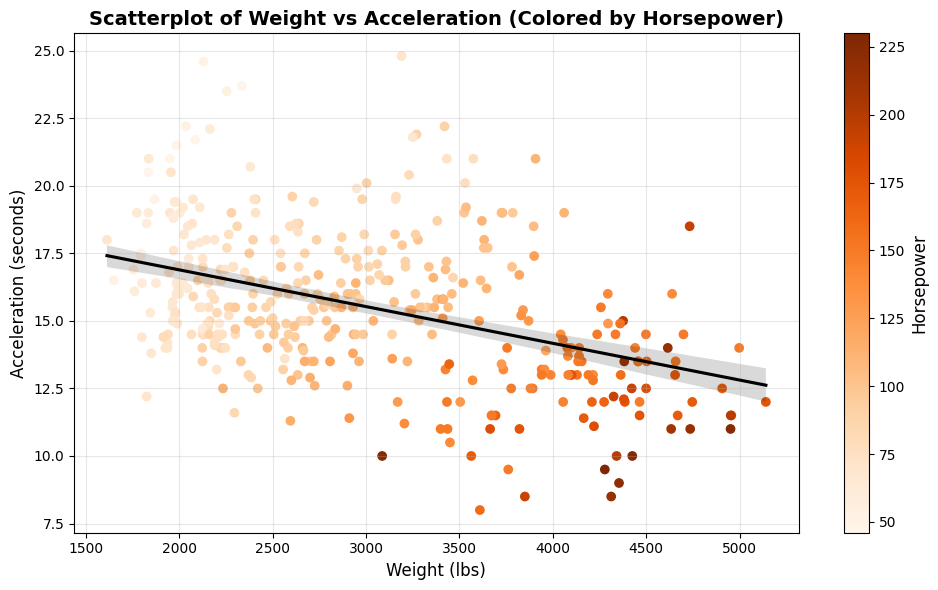

In [32]:
import numpy as np

# Create a scatterplot with color scale
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    x=cars_clean['weight'],
    y=cars_clean['acceleration'],
    c=cars_clean['horsepower'],  # Color scale based on horsepower
    cmap='Oranges'             # Color map
)

# Add the regression line
sns.regplot(
    data=cars_clean, x='weight', y='acceleration', scatter=False, line_kws={'color': 'k'}
)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Horsepower', fontsize=12)

# Add titles and labels
plt.title('Scatterplot of Weight vs Acceleration (Colored by Horsepower)', fontsize=14, weight='bold')
plt.xlabel('Weight (lbs)', fontsize=12)
plt.ylabel('Acceleration (seconds)', fontsize=12)
plt.grid(alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()
